# In this Notebook, I have Created Image Caption Generator using ResNet and Transformer Decoder Model. It can be divided into 2 steps :

Step 1 : Create features for Images Using Resnet

Step 2 : Train Transformer Decoder Model which predicts next word given a sequence of tokens and Image Features from Step1


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=False)

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Flickr8K_Dataset/captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


**Preprocessing -> Remove Single Character and non alpha Words. Add , and tokens. token is appended such that length in max_seq_len (maximum length across all captions which is 33 in our case)**

In [ ]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [ ]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))


In [ ]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [ ]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [ ]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


**Create Vocab and mapping of token to ID**

In [ ]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [ ]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


**Vocab size is 8360**

In [ ]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [ ]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


**Covert sequence of tokens to IDs**

In [ ]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [ ]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


**Split In Train and validation data. Same Image should not be present in both training and validation data**

In [ ]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [ ]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


**Extract features from Images Using Resnet**

In [ ]:
train_samples = len(train)
print(train_samples)

36409


In [ ]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = "/content/drive/My Drive/Flickr8K_Dataset/Images/"+ str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [ ]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [ ]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.9MB/s]


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [ ]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [ ]:
def get_vector(t_img):

    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)

    h.remove()
    return my_embedding

Don't re-run


Feature Extraction

In [ ]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/7282 [00:00<?, ?it/s]

In [ ]:
a_file = open('/content/drive/My Drive/Flickr8K_Dataset/EncodedImageTrainResNet.pkl', "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [ ]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_valid[image_name[0]] = embdg


  0%|          | 0/810 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
a_file = open('/content/drive/My Drive/Flickr8K_Dataset/EncodedImageValidResNet.pkl', "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

Run

**Create DataLoader which will be used to load data into Transformer Model.**

**FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.**

In [ ]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [ ]:
train_dataset_resnet = FlickerDataSetResnet(train, '/content/drive/My Drive/Flickr8K_Dataset/EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [ ]:
valid_dataset_resnet = FlickerDataSetResnet(valid, '/content/drive/My Drive/Flickr8K_Dataset/EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

**Create Transformer Decoder Model. This Model will take caption sequence and the extracted resnet image features as input and ouput 1 timestep shifted (left) caption sequence.**

**In the Transformer decoder, lookAhead and padding mask has also been applied**



**Position Embedding**

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]

        x = x + self.pe
        return self.dropout(x)

**Transformer Decoder**

In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)


        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)


        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

**Train the Model**

The cross entropy loss has been masked at time steps where input token is <'pad'>

In [ ]:
EPOCH = 30

In [ ]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float64('Inf')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)


    total_epoch_train_loss = total_epoch_train_loss/total_train_words


    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words

    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )

    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, '/content/drive/My Drive/Flickr8K_Dataset/BestModel1.0')
        min_val_loss = total_epoch_valid_loss


    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Lets Generate Captions !!!**

In [ ]:
# model = torch.load('/content/drive/My Drive/Flickr8K_Dataset/BestModel1.0')
# model = torch.load('/content/drive/My Drive/Flickr8K_Dataset/BestModel1.0', map_location='cpu', weights_only=False)
model = torch.load('/content/drive/My Drive/Flickr8K_Dataset/BestModel1.0', map_location='cuda', weights_only=False)
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
valid_img_embed = pd.read_pickle('/content/drive/My Drive/Flickr8K_Dataset/EncodedImageValidResNet.pkl')

**Here in the below function,we are generating caption in beam search. K defines the topK token to look at each time step**

In [ ]:
# def generate_caption(K, img_nm):
#     img_loc = "/content/drive/My Drive/Flickr8K_Dataset/Images/"+str(img_nm)
#     image = Image.open(img_loc).convert("RGB")
#     plt.imshow(image)

#     model.eval()
#     valid_img_df = valid[valid['image']==img_nm]
#     print("Actual Caption : ")
#     print(valid_img_df['caption'].tolist())
#     img_embed = valid_img_embed[img_nm].to(device)


#     img_embed = img_embed.permute(0,2,3,1)
#     img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


#     input_seq = [pad_token]*max_seq_len
#     input_seq[0] = start_token

#     input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
#     predicted_sentence = []
#     with torch.no_grad():
#         for eval_iter in range(0, max_seq_len):

#             output, padding_mask = model.forward(img_embed, input_seq)

#             output = output[eval_iter, 0, :]

#             values = torch.topk(output, K).values.tolist()
#             indices = torch.topk(output, K).indices.tolist()

#             next_word_index = random.choices(indices, values, k = 1)[0]

#             next_word = index_to_word[next_word_index]

#             input_seq[:, eval_iter+1] = next_word_index


#             if next_word == '<end>' :
#                 break

#             predicted_sentence.append(next_word)
#     print("\n")
#     print("Predicted caption : ")
#     print(" ".join(predicted_sentence+['.']))

In [ ]:
def generate_caption(K, img_nm):
    img_loc = "/content/drive/My Drive/Flickr8K_Dataset/Images/"+ str(img_nm)
    image = Image.open(img_loc).convert("RGB")

    model.eval()
    valid_img_df = valid[valid['image'] == img_nm]
    gt_captions = valid_img_df['caption'].tolist()  # Ground-truth captions

    img_embed = valid_img_embed[img_nm].to(device)
    img_embed = img_embed.permute(0, 2, 3, 1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    input_seq = [pad_token] * max_seq_len
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)

    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):
            output, _ = model.forward(img_embed, input_seq)
            output = output[eval_iter, 0, :]
            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()
            next_word_index = random.choices(indices, values, k=1)[0]
            next_word = index_to_word[next_word_index]
            input_seq[:, eval_iter+1] = next_word_index
            if next_word == '<end>':
                break
            predicted_sentence.append(next_word)

    return predicted_sentence, gt_captions


**1st Example**

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[50]['image'])

NameError: name 'model' is not defined

In [ ]:
generate_caption(2, unq_valid_imgs.iloc[50]['image'])

(['girl',
  'in',
  'pink',
  'top',
  'and',
  'blue',
  'jeans',
  'is',
  'jumping',
  'on',
  'swing'],
 ['Young child in pink top and purple pants clutching a turquoise guard rail .',
  'A very young girl is walking on a playground .',
  'The little girl is playing at the playground .',
  'A little girl in pink and purple stands on a playground .',
  'A female toddler wearing a pink shirt is playing on a playground .'])

**2nd Example**

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[100]['image'])


(['man', 'is', 'climbing', 'rock', 'wall'],
 ['A distant person is climbing up a very sheer mountain .',
  'A panoramic distance view of a rock climber going up a steep mountain wall .',
  'person rock climbing',
  'There is a person scaling a very steep rock wall .',
  'This person is climbing the side of a mountain .'])

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[105]['image'])

(['man', 'and', 'woman', 'walking', 'down', 'city', 'street'],
 ['There are two blue signs on the corner of the street .',
  'People stand outside of a building that has cars parked in front .',
  'Cobblestone street and line of storefronts',
  'A street view with cars and buildings .',
  'cars are parked by a little store in quaint European street .'])

In [ ]:
generate_caption(3, unq_valid_imgs.iloc[105]['image'])

IndexError: index 33 is out of bounds for dimension 1 with size 33

In [ ]:
generate_caption(3, unq_valid_imgs.iloc[112]['image'])

(['young', 'man', 'is', 'riding', 'bicycle', 'down', 'dirt', 'road'],
 ['A hiker wearing an orange backpack is walking through long grass .',
  'A man walking in brush with a big orange backpack .',
  'A man with an orange backpack in an bushy area .',
  'A person with a large backpack hiking through the tall grass .',
  'The hiker with a black and orange backpack walks away into the wooded area .'])

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[108]['image'])

(['dog', 'is', 'sitting', 'on', 'the', 'ground', 'next', 'to', 'woman'],
 ['Two brown dogs are laying on the street next to a metal pole .',
  'two dogs are chained to a pole .',
  'Two dogs are tied to a tree in a city .',
  'Two dogs tied to a tree .',
  'Two small dogs sit near a tree .'])

Actual Caption : 
['Two brown dogs are laying on the street next to a metal pole .', 'two dogs are chained to a pole .', 'Two dogs are tied to a tree in a city .', 'Two dogs tied to a tree .', 'Two small dogs sit near a tree .']


Predicted caption : 
two brown dog are standing on the floor of wooden structure and the snow with its tongue out .


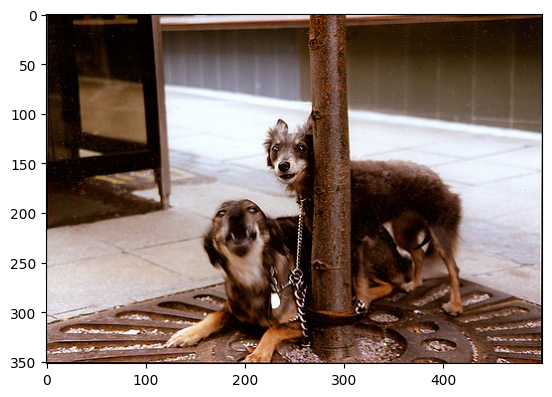

In [ ]:
generate_caption(3, unq_valid_imgs.iloc[108]['image'])

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[227]['image'])

(['two', 'dogs', 'are', 'playing', 'together', 'on', 'grass'],
 ['Two large brown dogs are both grabbing a black Frisbee .',
  'Two dogs holding one Frisbee in their mouths .',
  'Two dogs holding a single black Frisbee in their mouths',
  'Two brown dogs are biting on a black Frisbee .',
  'Two dogs are wrestling over a piece of black material .'])

Actual Caption : 
['Two large brown dogs are both grabbing a black Frisbee .', 'Two dogs holding one Frisbee in their mouths .', 'Two dogs holding a single black Frisbee in their mouths', 'Two brown dogs are biting on a black Frisbee .', 'Two dogs are wrestling over a piece of black material .']


Predicted caption : 
brown dog with blue collar runs in the grass with his tongue hanging out .


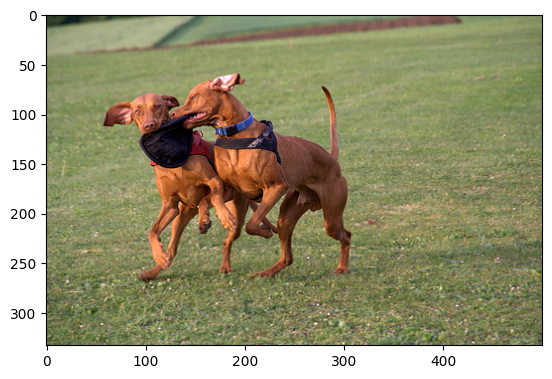

In [ ]:
generate_caption(2, unq_valid_imgs.iloc[227]['image'])

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothie = SmoothingFunction().method4

bleu_scores = []

for img_nm in unq_valid_imgs['image'][:50]:  # limit to 50 images
    pred_caption, ref_captions = generate_caption(K=1, img_nm=img_nm)

    references = [ref.lower().split() for ref in ref_captions]
    candidate = pred_caption

    bleu1 = sentence_bleu(references, candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = sentence_bleu(references, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    bleu_scores.append((bleu1, bleu2, bleu3, bleu4))

# Calculate average scores
avg_bleu = list(map(lambda i: sum(x[i] for x in bleu_scores)/len(bleu_scores), range(4)))
print(f"BLEU-1: {avg_bleu[0]:.4f}, BLEU-2: {avg_bleu[1]:.4f}, BLEU-3: {avg_bleu[2]:.4f}, BLEU-4: {avg_bleu[3]:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


BLEU-1: 0.4333, BLEU-2: 0.2574, BLEU-3: 0.1525, BLEU-4: 0.0967
